# Requirements

In [1]:
! pip install simpletransformers
! pip install emoji
! pip install contractions
! pip install twitter-text-parser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 16

In [2]:
import json
import os
from tqdm import tqdm; tqdm.pandas()
import pandas as pd
from emoji import demojize
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import StratifiedKFold
from simpletransformers.classification import ClassificationModel
import torch
import contractions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import json
from twitter_text import parse_tweet, extract_urls_with_indices, extract_emojis_with_indices
from collections import Counter
import spacy
from spacy.lang.en import English

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Feger/twitter-taco-dataset

/content/drive/MyDrive/Colab Notebooks/Feger/twitter-taco-dataset


In [4]:
ARGUMENT = 'Argument'
NOARGUMENT = 'No-Argument'

NONE = "None"
NOTIFICATION = "Notification"
STATEMENT = "Statement"
REASON = "Reason"

category2id = {REASON: 0, STATEMENT: 1, NOTIFICATION: 2, NONE: 3}
class2id = {NOARGUMENT: 0, ARGUMENT: 1}

UNDECIDED = 'Undecided'

CV_OUTPUT = './outputs/bertweet_cv_predictions.csv'

# Data Preparation

In [5]:
tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return contractions.fix(token)

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [6]:
df_majority = pd.read_csv('./data/majority_votes.csv', index_col='tweet_id')
df_backup = pd.read_csv('./data/backup_tweets.csv', index_col='tweet_id', lineterminator='\n')

df_majority = df_majority[df_majority['category'] != UNDECIDED].copy()
df_majority['category'] = df_majority.category.replace(category2id)
df_majority = df_majority.merge(right=df_backup, on='tweet_id')
df_majority['text'] = df_majority.progress_apply(lambda row: normalizeTweet(row.text), axis=1)

100%|██████████| 1734/1734 [00:01<00:00, 1453.11it/s]


# Cross-Validation

In [7]:
skf = StratifiedKFold(n_splits=10, random_state=123456789, shuffle=True)

df_predictions = pd.DataFrame()

model_args = {
    "num_train_epochs": 5,
    "train_batch_size": 8,
    "eval_batch_size": 8,
    "learning_rate": 4e-5,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "overwrite_output_dir": True,
    "no_cache": True,
    "no_save": True
}

if not os.path.exists(CV_OUTPUT):

    for train_index, test_index in skf.split(df_majority, df_majority.category):
        df_train = df_majority.iloc[train_index][['text', 'category']].copy()
        df_test = df_majority.iloc[test_index][['text', 'category']].copy()
        
        simple_transformer = ClassificationModel('bertweet',
                                                 'vinai/bertweet-base',
                                                 use_cuda=torch.cuda.is_available(),
                                                 num_labels=4,
                                                 args=model_args)
    
        simple_transformer.train_model(df_train)
        predictions, _ = simple_transformer.predict(df_test.text.to_list())
        df_test['category_pred'] = predictions
        df_predictions = pd.concat([df_predictions, df_test[['category', 'category_pred']]])

    assert df_predictions.sort_index().index.equals(df_majority.sort_index().index)
    assert df_predictions.index.shape[0] == df_majority.index.shape[0]
    assert sorted(set(df_predictions.index)) == sorted(set(df_majority.index))

    df_predictions.to_csv(CV_OUTPUT)

# Evaluation

In [8]:
df_validation = pd.read_csv(CV_OUTPUT)
df_validation = df_validation.set_index('tweet_id')

assert sorted(df_majority.index) == sorted(df_validation.index)
assert sorted(df_validation.index) == sorted(df_majority.index)

for tweet_id in df_majority.index:
    assert df_majority.loc[tweet_id].category == df_validation.loc[tweet_id].category

df_validation = df_validation.merge(df_backup, on=['tweet_id'])

y_true = df_validation.category.to_list()
y_pred = df_validation.category_pred.to_list()

y_true_bin = [y in [category2id[REASON], category2id[STATEMENT]] for y in y_true]
y_pred_bin = [y in [category2id[REASON], category2id[STATEMENT]] for y in y_pred]

In [9]:
# binary classification evaluation
print(classification_report(y_true_bin, y_pred_bin, target_names=class2id.keys(), digits=4))

              precision    recall  f1-score   support

 No-Argument     0.8666    0.8297    0.8477       869
    Argument     0.8359    0.8717    0.8534       865

    accuracy                         0.8506      1734
   macro avg     0.8513    0.8507    0.8506      1734
weighted avg     0.8513    0.8506    0.8506      1734



In [10]:
# multi-class classification evaluation
print(classification_report(y_true, y_pred, target_names=category2id.keys(), digits=4))

              precision    recall  f1-score   support

      Reason     0.7369    0.7522    0.7445       581
   Statement     0.5437    0.5915    0.5666       284
Notification     0.7902    0.7760    0.7830       500
        None     0.8387    0.7751    0.8056       369

    accuracy                         0.7376      1734
   macro avg     0.7274    0.7237    0.7249      1734
weighted avg     0.7423    0.7376    0.7395      1734



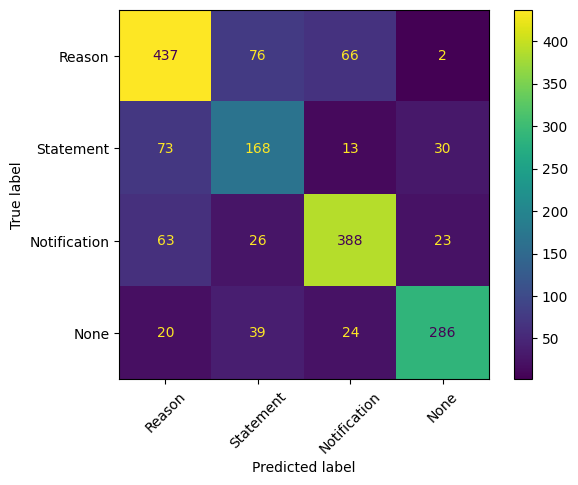

In [11]:
# y_true is a 1D array of true class labels, and y_pred is a 1D array of predicted class labels
cm = confusion_matrix(y_true, y_pred)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category2id.keys())
disp.plot(xticks_rotation=45)

In [12]:
# error tracing
with open('./data/url_dict.json') as json_file:
    url_dict = json.load(json_file)

def add_information(df):
    df = df.copy()
    nlp = English()

    def process_url(tweet_text, lookup):
        urls = extract_urls_with_indices(tweet_text)
        has_external_url = any('twitter.com' not in url_dict.get(url['url'], None) for url in urls)
        return int(has_external_url)

    def process_emojis(tweet_text):
        return len(extract_emojis_with_indices(tweet_text)) > 0

    def detect_discourse_markers(text):
        discourse_markers = ["actually", "anyway", "basically", "certainly", "clearly", "consequently", "definitely", "evidently",
                     "generally", "however", "incidentally", "indeed", "interestingly", "likewise", "meanwhile", "moreover",
                     "nevertheless", "obviously", "overall", "personally", "previously", "really", "right", "so", "somehow",
                     "sometimes", "specifically", "still", "technically", "therefore", "thus", "unfortunately", "well", "whatever",
                     "whenever", "whereas", "whether", "while", "yet"]
        doc = nlp(text)
        markers = []
        for token in doc:
            if token.lower_ in discourse_markers:
                markers.append(token.lower_)
        return markers
    
    df['length'] = df.progress_apply(lambda row: parse_tweet(row.text).weightedLength, axis=1)
    df['urls'] = df.progress_apply(lambda row: len(extract_urls_with_indices(row.text)), axis=1)
    df['has_external_url'] = df.progress_apply(lambda row: process_url(row.text, url_dict), axis=1)
    df['emojis'] = df.progress_apply(lambda row: len(extract_emojis_with_indices(row.text)), axis=1)
    df['hashtags'] = df.progress_apply(lambda row: Counter(row.text).get('#', 0), axis=1)
    df['users'] = df.progress_apply(lambda row: Counter(row.text).get('@', 0), axis=1)
    df['marker'] = df.progress_apply(lambda row: len(detect_discourse_markers(row.text)), axis=1)

    return df

In [13]:
df_missclassification = add_information(df_validation[(df_validation.category == category2id[STATEMENT]) & 
                                       (
                                           (df_validation.category_pred == category2id[REASON]) |
                                           (df_validation.category_pred == category2id[NOTIFICATION])
                                       )])

100%|██████████| 86/86 [00:00<00:00, 282.62it/s]


In [14]:
df_statement = add_information(df_validation[df_validation.category == category2id[STATEMENT]])
print("\nCharacteristics class Statement:")
print("Mean Length:", df_statement['length'].describe()['mean'])
print(" % urls > 0:", round(100*(df_statement[df_statement.urls > 0].shape[0]/df_statement.shape[0]), 2))
print("     % external > 0:", round(100*(df_statement[(df_statement.urls > 0) & (df_statement.has_external_url > 0)].shape[0]/df_statement[df_statement.urls > 0].shape[0]), 2))
print(" % marker > 0:", round(100*(df_statement[df_statement.marker > 0].shape[0]/df_statement.shape[0]), 2))


print("Miss-classifications for class Statement:")
print("Mean Length:", df_missclassification['length'].describe()['mean'])
print(" % urls > 0:", round(100*(df_missclassification[df_missclassification.urls > 0].shape[0]/df_missclassification.shape[0]), 2))
print("     % external > 0:", round(100*(df_missclassification[(df_missclassification.urls > 0) & (df_missclassification.has_external_url > 0)].shape[0]/df_missclassification[df_missclassification.urls > 0].shape[0]), 2))
print(" % marker > 0:", round(100*(df_missclassification[df_missclassification.marker > 0].shape[0]/df_missclassification.shape[0]), 2))

100%|██████████| 284/284 [00:00<00:00, 792.51it/s]


Characteristics class Statement:
Mean Length: 121.63028169014085
 % urls > 0: 8.1
     % external > 0: 17.39
 % marker > 0: 19.01
Miss-classifications for class Statement:
Mean Length: 171.8139534883721
 % urls > 0: 22.09
     % external > 0: 15.79
 % marker > 0: 24.42
